<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020/blob/main/mnist_cnn_kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hand-written digits classification with k-folding**

In [1]:
'''Trains a simple deep NN on the MNIST dataset.

Gets to 99.6% test accuracy after 40 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import RMSprop, Adam, Adadelta
from keras.callbacks import EarlyStopping

from keras.utils.vis_utils import plot_model
from IPython.display import Image 

from sklearn.model_selection import KFold

batch_size = 128
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)



x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train0, num_classes)
y_test = keras.utils.to_categorical(y_test0, num_classes)



11493376/11490434 [==============================] - 0s 0us/step
60000 train samples
10000 test samples


# **Reduce the dataset size**

In [2]:
N_TRAIN_EXAMPLES = 30000 #3000
N_TEST_EXAMPLES = 10000

x_train = x_train[:N_TRAIN_EXAMPLES]
x_test = x_test[:N_TEST_EXAMPLES]
y_train = y_train[:N_TRAIN_EXAMPLES]
y_test = y_test[:N_TEST_EXAMPLES]

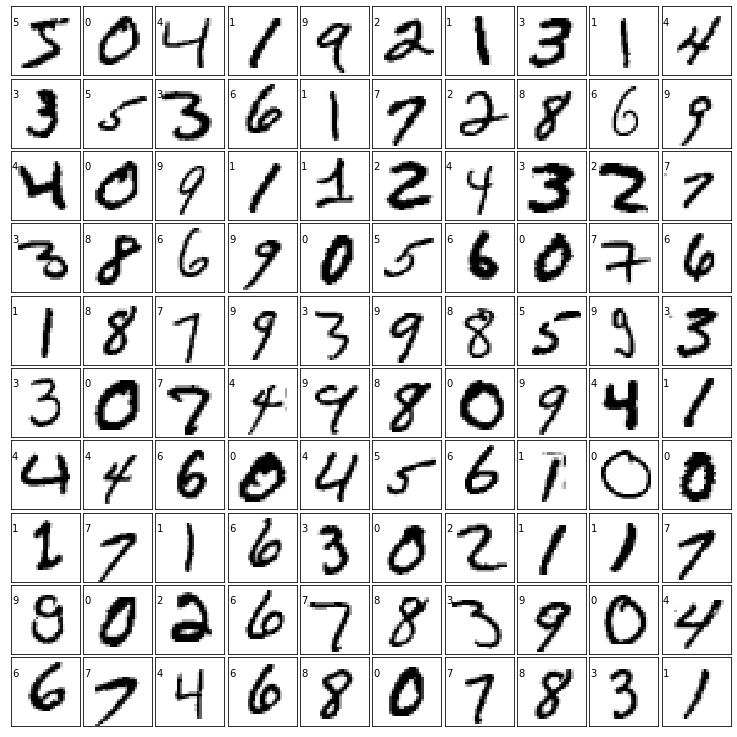

In [3]:
#visualize the digits

fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(y_train0[i]))

In [4]:
def define_model():
# Our old fully connected (dense) network
#model = Sequential()
#model.add(Dense(512, activation='relu', input_shape=(784,)))
#model.add(Dropout(0.2))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(num_classes, activation='softmax'))

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))



  #model.summary()

  return model

In [5]:
def plotModel(model):
  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
  Image('model_plot.png')

In [6]:
def fit_model(model, x_train, y_train, x_val, y_val):
  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
  
  es = EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=0
  )

  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=[es])
  return history, model

# **Train with k-folding**

In [7]:

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
    model = define_model()
    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
    history, model = fit_model(model, trainX, trainY, testX, testY)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
		# stores scores
    scores.append(acc)
    histories.append(history)
    models.append(model)
  return scores, histories, models

# **Make plots**

In [8]:
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.ylim(0.9,1)
    plt.legend(['accuracy','val_accuracy'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()

# **Perform training**

In [9]:
	scores, histories, models = list(), list(), list()
  
  # evaluate model
	scores, histories, models = evaluate_model(x_train, y_train, n_folds=10)


Epoch 1/20
211/211 [==============================] - 2s 10ms/step - loss: 0.5064 - accuracy: 0.8346 - val_loss: 0.1000 - val_accuracy: 0.9660
Epoch 2/20
211/211 [==============================] - 2s 9ms/step - loss: 0.1374 - accuracy: 0.9584 - val_loss: 0.0566 - val_accuracy: 0.9767
Epoch 3/20
211/211 [==============================] - 2s 9ms/step - loss: 0.0957 - accuracy: 0.9715 - val_loss: 0.0372 - val_accuracy: 0.9890
Epoch 4/20
211/211 [==============================] - 2s 9ms/step - loss: 0.0759 - accuracy: 0.9766 - val_loss: 0.0344 - val_accuracy: 0.9870
Epoch 5/20
211/211 [==============================] - 2s 9ms/step - loss: 0.0621 - accuracy: 0.9811 - val_loss: 0.0337 - val_accuracy: 0.9863
Epoch 6/20
211/211 [==============================] - 2s 9ms/step - loss: 0.0557 - accuracy: 0.9831 - val_loss: 0.0339 - val_accuracy: 0.9877
Epoch 7/20
211/211 [==============================] - 2s 9ms/step - loss: 0.0487 - accuracy: 0.9859 - val_loss: 0.0292 - val_accuracy: 0.9920
Epoch

# **Summarize**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


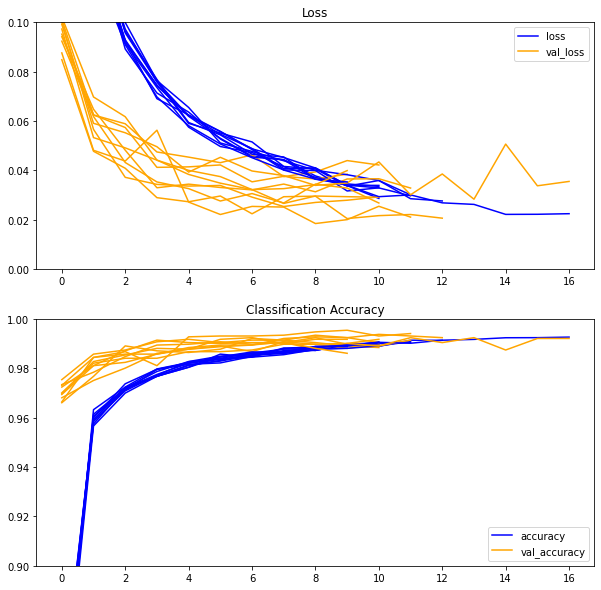

Accuracy: mean=99.073 std=0.215, n=10


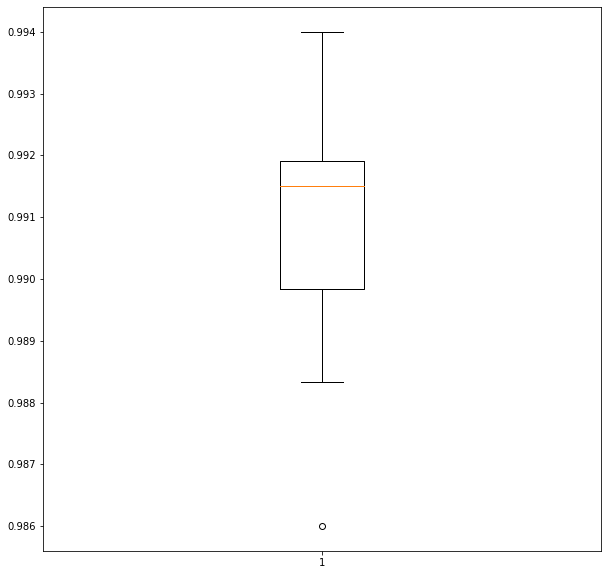

Scores:  [0.9883333444595337, 0.9923333525657654, 0.9896666407585144, 0.9916666746139526, 0.9940000176429749, 0.9916666746139526, 0.9913333058357239, 0.9903333187103271, 0.9919999837875366, 0.9860000014305115]


In [10]:
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)

# **Ensamble of networks**

In [11]:
results = np.zeros(y_test.shape)
for j in range(len(models)):
    results = results + models[j].predict(x_test)

results = results / len(models)
results = np.argmax(results,axis = 1)
Yresults = np.argmax(y_test,axis = 1)

#print(results.shape)


score = (len(results) - np.count_nonzero(results-Yresults))/len(results)

print("Ensamble test accuracy: ",score*100.,"%")


Ensamble test accuracy:  99.42999999999999 %


In [12]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix


#confusion matrix
cm = confusion_matrix(Yresults,results)
print(cm)



[[ 977    0    0    0    0    0    2    1    0    0]
 [   0 1134    0    0    0    1    0    0    0    0]
 [   1    0 1029    0    0    0    0    2    0    0]
 [   0    0    1 1006    0    2    0    0    1    0]
 [   0    0    0    0  977    0    1    0    1    3]
 [   1    0    0    5    0  884    1    1    0    0]
 [   3    2    0    0    1    1  949    0    2    0]
 [   0    2    5    0    0    0    0 1020    0    1]
 [   2    0    2    1    0    0    0    0  968    1]
 [   0    0    0    0    4    2    0    3    1  999]]


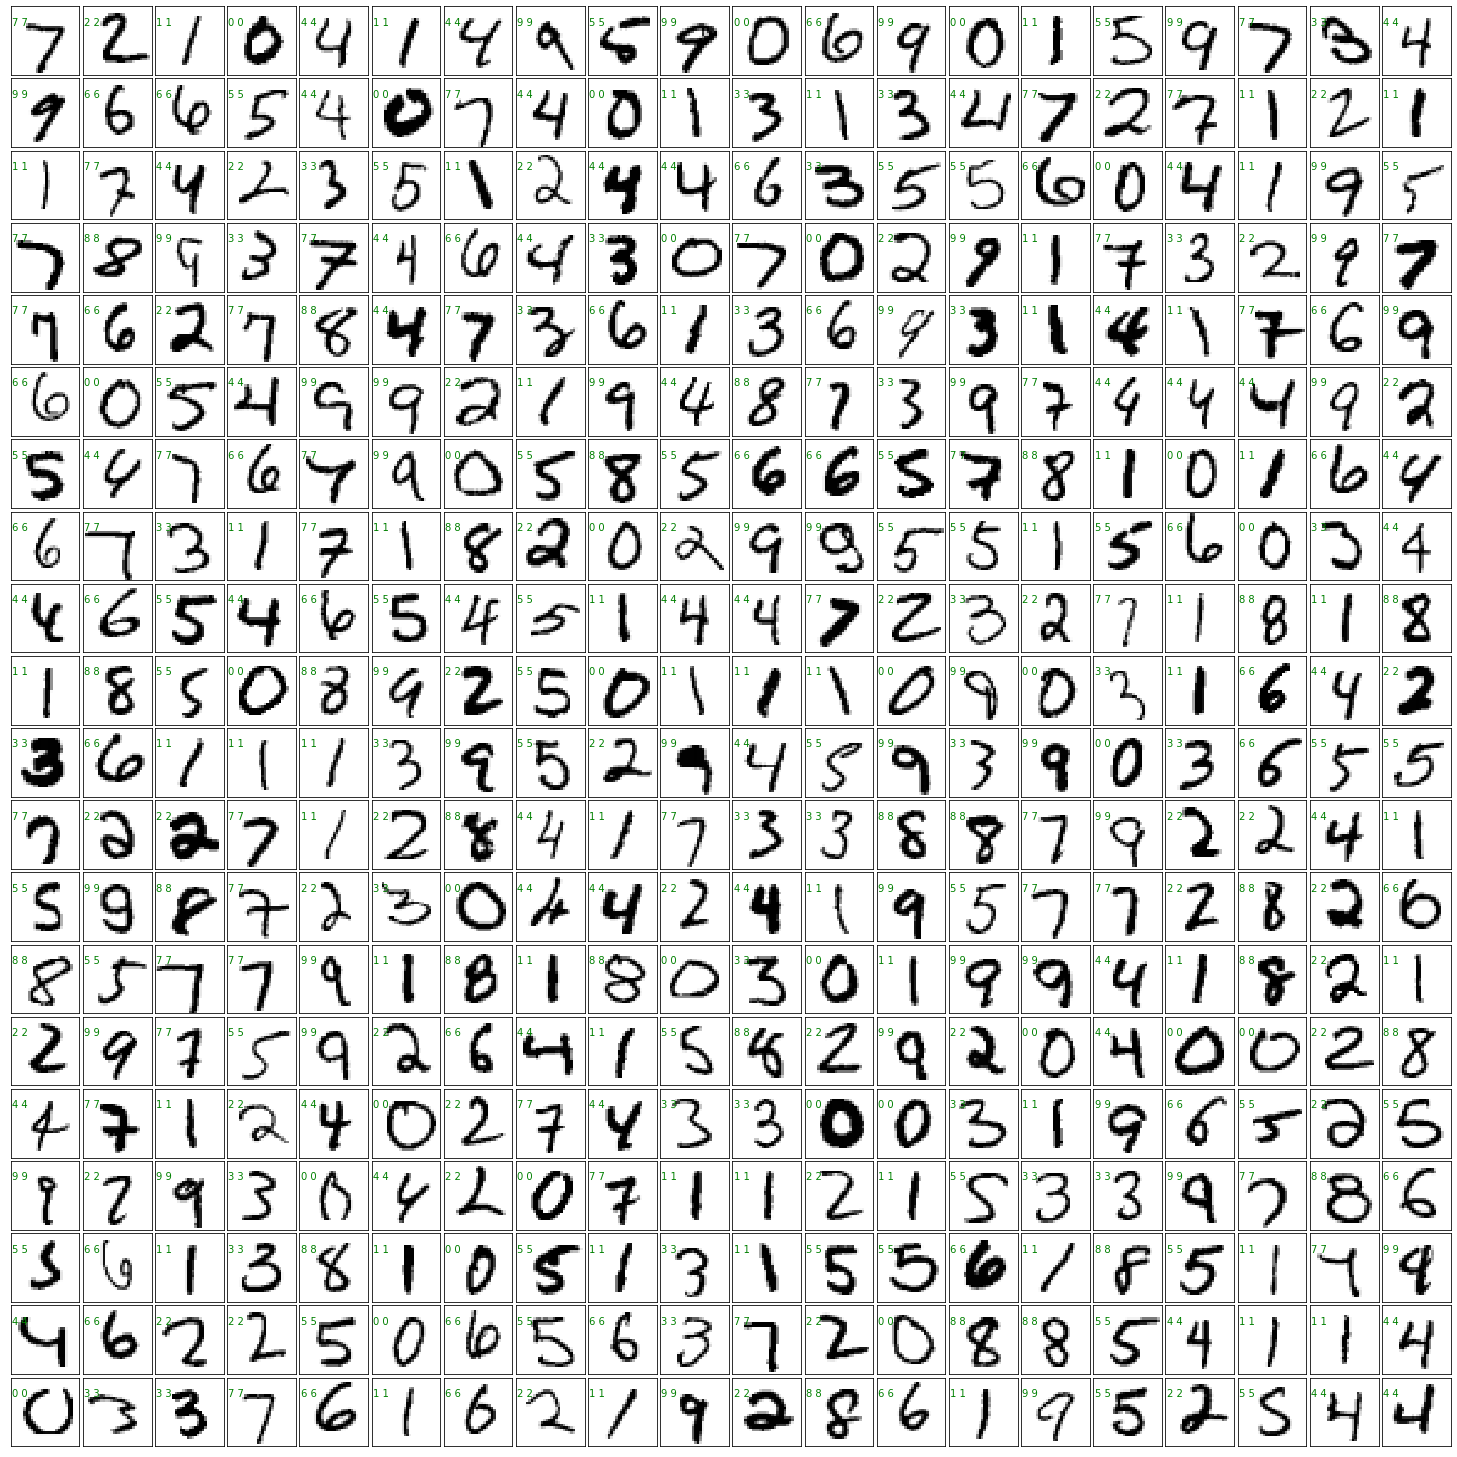

In [13]:
# use the model to predict the labels of the test data
predicted = results
expected = Yresults

#print(predicted.shape, expected.shape)

# Plot the prediction
fig = plt.figure(figsize=(20, 20))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


# plot the digits: each image is 28x28 pixels
for i in range(400):
    ax = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    if predicted[i] == expected[i]:
         ax.text(0,7,str(expected[i])+" "+str(predicted[i]), color='green')
    else:
         ax.text(0,7,str(expected[i])+" "+str(predicted[i]), color='red')
